# CNCITY - cassandraConnect


# Importing python packages 

In [1]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
import os
import sys

# Data Analysis
import pandas as pd

# Cassandra
from connection_manager import cassandraConnect
from cassandra.query import dict_factory

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import tqdm as tqdm
from tabulate import tabulate
import time


# Importing the dataset - df = 20240603

In [4]:
PORT = 9042
KEYSPACE = "cncity_server"
TABLE = "all_data"

# Source DB
CONTACT_POINTS = ["39.118.41.24"]
USERNAME = "cnscada"
PW = "cnscada123!@#"

cc = cassandraConnect(CONTACT_POINTS, USERNAME, PW)
cc.session.row_factory = dict_factory

Connected to Cassandra Successfully: ['39.118.41.24'] 9042


In [5]:
use_machine_code = 1
use_day = 20240603
# save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

###################################

query = """
    SELECT *
    FROM {keyspace_name}.{table_name}
    WHERE machine_code = {query_machine_code}
    AND day = {query_day}
""".format(
    keyspace_name = KEYSPACE,
    table_name = TABLE,
    query_machine_code = use_machine_code,
    query_day = use_day
)

query_result = cc.session.execute(query)
###################################

# Pandas DataFrame으로 전환
df_1 = pd.DataFrame(list(query_result)).sort_values(by='time')
# df.to_csv(save_path, index=False)

print(df_1.shape)
df_1.head()

(86261, 22)


,machine_code,day,time,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
86260,1,20240603,0,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86259,1,20240603,1,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86258,1,20240603,2,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.130,0,0,0,0,0,0,0
86257,1,20240603,3,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.144,0,0,0,0,0,0,0
86256,1,20240603,4,0,-1385.0,0.0,0,0,1,0,...,0,0.798,2.144,0,0,0,0,0,0,0


# Functions - Query, process_dataframe, convert_dates, create_time_column, etc

In [7]:
def query(day, machine_code):
    use_machine_code = machine_code
    use_day = day
    # save_path = os.path.join('.', 'data', f'Machine{use_machine_code}_{use_day}.csv')

    ###################################

    query = """
        SELECT *
        FROM {keyspace_name}.{table_name}
        WHERE machine_code = {query_machine_code}
        AND day = {query_day}
    """.format(
        keyspace_name = KEYSPACE,
        table_name = TABLE,
        query_machine_code = use_machine_code,
        query_day = use_day
    )

    query_result = cc.session.execute(query)
    ###################################

    # Pandas DataFrame으로 전환
    df_1 = pd.DataFrame(list(query_result)).sort_values(by='time')
    # df.to_csv(save_path, index=False)

    # print(df_1.shape)
    # print(df_1.head())
    return df_1


In [8]:
def process_dataframe(df, aggregation):
    # Extract hour from 'Time' column (assuming 'Time' is in seconds since midnight)
    df['Hour'] = df['time'].dropna() // 10000
    
    # Group by 'Hour' and aggregate the data
    if aggregation == 'mean':
        result_df = df.groupby('Hour').mean().reset_index()
    elif aggregation == 'median':
        result_df = df.groupby('Hour').median().reset_index()
    elif aggregation == 'mode':
        # Mode can return multiple values, we need the first one
        result_df = df.groupby('Hour').agg(lambda x: x.mode().iloc[0]).reset_index()
    elif aggregation == 'max': 
        result_df = df.groupby('Hour').max().reset_index()
    elif aggregation == 'min':
        result_df = df.groupby('Hour').min().reset_index()
    else:
        raise ValueError("Aggregation method not supported. Use 'mean', 'median', or 'mode'.")
    
    # Drop the 'Time' column as it's not needed in the result
    result_df = result_df.drop(columns=['time'])
    
    return result_df

# result_df = process_dataframe(df,'max')

In [9]:
def convert_dates(df): #converts the values in the date column into datetime objects
    df = df
    day_list = list(df['day'])
    new_date_list = []
    for item in day_list:
        day_string = str(item)
        day_datetime = datetime.strptime(day_string, '%Y%m%d')
        new_date_list.append(day_datetime)

    df['day'] = new_date_list


In [10]:
def create_time_column(df): #concatenates the time and date column values 
    df = df
    hour_list = list(df['Hour'])
    new_hour_list = []
    for i in range(24):
        new_hour_list.append(f"{i}:00")
    
    df['Hour'] = new_hour_list * 30
    df['Hour'] = pd.to_datetime(df['Hour'], format='%H:%M') - pd.to_datetime(df['Hour'], format='%H:%M').dt.normalize()

    df['Time'] = df['day'] + df['Hour']


# February (20240201 ~ 20240228)

In [ ]:
processed_dataframe_list_3 = []
start_date = 20240201

while start_date < 20240228:
    df = query(start_date, 1)
    new_df = process_dataframe(df, 'max')
    processed_dataframe_list_3.append(new_df)
    start_date+=1

del df
del new_df

final_df_3 = pd.concat(processed_dataframe_list_3, axis =0)

final_df_3.head()

,Hour,machine_code,day,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
0,0,1,20240201,0,-1408.0,0.0,0,0,1,0,...,0,0.781,2.167,0,0,0,0,0,0,0
1,1,1,20240201,0,-1404.0,0.0,0,0,1,0,...,0,0.784,2.173,0,0,0,0,0,0,0
2,2,1,20240201,0,-1408.0,0.0,0,0,1,0,...,0,0.784,2.174,0,0,0,0,0,0,0
3,3,1,20240201,0,-1407.0,0.0,0,0,1,0,...,0,0.781,2.169,0,0,0,0,0,0,0
4,4,1,20240201,0,-1401.0,0.0,0,0,1,0,...,0,0.773,2.155,0,0,0,0,0,0,0


In [ ]:
final_df_33 = final_df_3.copy()
day_list_2 = list(final_df_33['day'])

In [ ]:
new_date_list_2 = []
for item in day_list_2:
    day_string = str(item)
    day_datetime = datetime.strptime(day_string, '%Y%m%d')
    new_date_list_2.append(day_datetime)

final_df_33['day'] = new_date_list_2

final_df_33['day']

0    2024-02-01
1    2024-02-01
2    2024-02-01
3    2024-02-01
4    2024-02-01
        ...    
19   2024-02-27
20   2024-02-27
21   2024-02-27
22   2024-02-27
23   2024-02-27
Name: day, Length: 644, dtype: datetime64[ns]

In [ ]:
day_list_2 = []
start_date_2 =20240201
while start_date_2 < 20240228:
    day_list_2.append(start_date_2)
    start_date_2 +=1 


In [ ]:
plot_kmeans_results(final_df_33['hour'],final_df_33['pressure_2'])

NameError: name 'final_df_33' is not defined

# April (20240401 ~ 20240430)

In [44]:
processed_dataframe_list_2 = []
start_date = 20240401

while start_date < 20240430:
    df = query(start_date,1)
    new_df = process_dataframe(df,'max')
    processed_dataframe_list_2.append(new_df)
    start_date+=1
del df
del new_df
final_df_2 = pd.concat(processed_dataframe_list_2, axis = 0)

final_df_2.head()


,Hour,machine_code,day,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,...,power_on,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime
0,0,1,20240401,0,-1245.0,0.0,0,0,1,0,...,0,0.793,2.151,0,0,0,0,0,0,0
1,1,1,20240401,0,-1245.0,0.0,0,0,1,0,...,0,0.794,2.164,0,0,0,0,0,0,0
2,2,1,20240401,0,-1239.0,0.0,0,0,1,0,...,0,0.793,2.173,0,0,0,0,0,0,0
3,3,1,20240401,0,-1236.0,0.0,0,0,1,0,...,0,0.792,2.153,0,0,0,0,0,0,0
4,4,1,20240401,0,-1231.0,0.0,0,0,1,0,...,0,0.787,2.142,0,0,0,0,0,0,0


In [189]:
# convert_dates(final_df_2)
final_df_2['Hour']

0      0:00
1      1:00
2      2:00
3      3:00
4      4:00
      ...  
19    19:00
20    20:00
21    21:00
22    22:00
23    23:00
Name: Hour, Length: 696, dtype: object

In [ ]:
final_22_condensed = final_df_22[['day','Hour','pressure_2']]
final_22_condensed = final_22_condensed.reset_index()
del final_22_condensed['index']

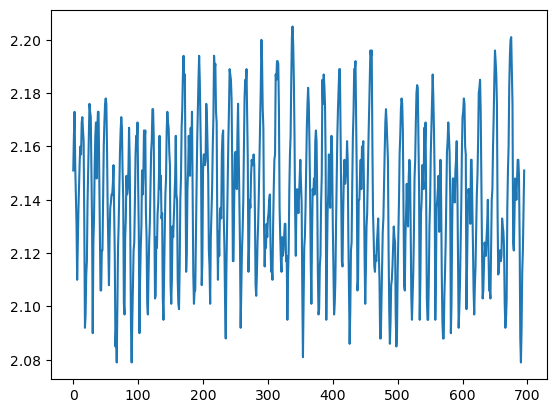

In [48]:
final_condensed_April = final_df_22[['day','Hour','pressure_2']]
final_condensed_April = final_condensed_April.reset_index()
del final_condensed_April['index']

final_condensed_April

plt.plot(final_condensed_April['pressure_2'])

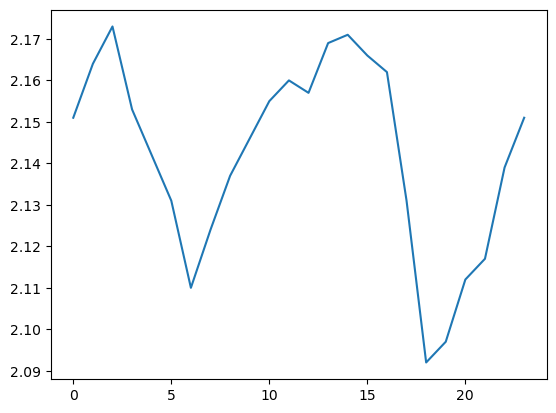

In [49]:
plt.plot(final_condensed_April['pressure_2'].head(24))

In [101]:
hour_list = list(final_df_22['Hour'])
new_hour_list = []
for i in range(24):
    new_hour_list.append(f"{i}:00")

final_df_22['Hour'] = new_hour_list * 29

final_df_22['Hour']

0      0:00
1      1:00
2      2:00
3      3:00
4      4:00
      ...  
19    19:00
20    20:00
21    21:00
22    22:00
23    23:00
Name: Hour, Length: 696, dtype: object

In [102]:
import time
hour_list_2 = list(final_df_22['Hour'])
final_df_22['Hour'] = new_hour_list * 29
final_df_22['Hour']

0      0:00
1      1:00
2      2:00
3      3:00
4      4:00
      ...  
19    19:00
20    20:00
21    21:00
22    22:00
23    23:00
Name: Hour, Length: 696, dtype: object

In [126]:
# pd.to_datetime(final_df_22['Hour'], format='%H:%M') - pd.to_datetime(final_df_22['Hour'], format='%H:%M').dt.normalize()
# final_df_22['Hour']
new_df_time = final_df_22[['day','Hour']]
final_df_22['Time'] = final_df_22['day'] + final_df_22['Hour']
final_df_22['Time']

0    2024-04-01 00:00:00
1    2024-04-01 01:00:00
2    2024-04-01 02:00:00
3    2024-04-01 03:00:00
4    2024-04-01 04:00:00
             ...        
19   2024-04-29 19:00:00
20   2024-04-29 20:00:00
21   2024-04-29 21:00:00
22   2024-04-29 22:00:00
23   2024-04-29 23:00:00
Name: Time, Length: 696, dtype: datetime64[ns]

In [134]:
final_df_clean = final_df_22.drop(['Hour','day'],axis = 1)
final_df_clean

,machine_code,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,outside_temperature,panel_open,...,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime,Time
0,1,0,-1245.0,0.0,0,0,1,0,5.3,0,...,0.793,2.151,0,0,0,0,0,0,0,2024-04-01 00:00:00
1,1,0,-1245.0,0.0,0,0,1,0,5.2,0,...,0.794,2.164,0,0,0,0,0,0,0,2024-04-01 01:00:00
2,1,0,-1239.0,0.0,0,0,1,0,4.4,0,...,0.793,2.173,0,0,0,0,0,0,0,2024-04-01 02:00:00
3,1,0,-1236.0,0.0,0,0,1,0,3.8,0,...,0.792,2.153,0,0,0,0,0,0,0,2024-04-01 03:00:00
4,1,0,-1231.0,0.0,0,0,1,0,2.8,0,...,0.787,2.142,0,0,0,0,0,0,0,2024-04-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,1,0,-1385.0,0.0,0,0,1,0,15.5,0,...,0.786,2.092,0,0,0,0,0,0,0,2024-04-29 19:00:00
20,1,0,-1385.0,0.0,0,0,1,0,15.2,0,...,0.790,2.113,0,0,0,0,0,0,0,2024-04-29 20:00:00
21,1,0,-1387.0,0.0,0,0,1,0,15.2,0,...,0.792,2.121,0,0,0,0,0,0,0,2024-04-29 21:00:00
22,1,0,-1385.0,0.0,0,0,1,0,14.9,0,...,0.795,2.135,0,0,0,0,0,0,0,2024-04-29 22:00:00


In [142]:
# unique_dates = final_df_22['day'].unique()
# fig, ax = plt.subplots(len(unique_dates), 1, figsize=(15, len(unique_dates) * 5))

# for i, date in enumerate(unique_dates):
#     daily_data = final_df_22[final_df_22['day'] == date]
#     ax[i].plot(daily_data['Hour'], daily_data['pressure_2'], label='Variable1')
#     # ax[i].plot(daily_data['Hour'], daily_data['Variable2'], label='Variable2')
#     ax[i].set_title(f'Variables on {date.strftime("%Y-%m-%d")}')
#     ax[i].set_xlabel('Hour')
#     ax[i].set_ylabel('Values')
#     ax[i].legend()

# plt.tight_layout()
# plt.show()

In [35]:
day_list = []
start_date = 20240401
while start_date < 20240430:
    day_list.append(start_date)
    start_date+=1


<b> April - pressure_2 </b>

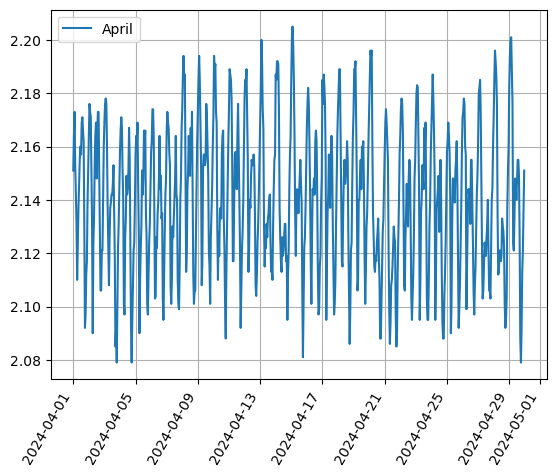

In [ ]:
plot_kmeans_results(final_df_clean['Time'],final_df_clean['pressure_2'])

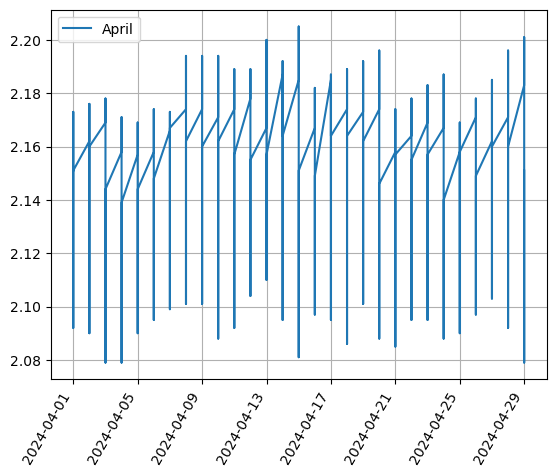

In [ ]:
plot_kmeans_results(final_df_22['day'], final_df_22['pressure_2'])

# Jan + Feb + March + April + May + June (2023): preprocessed 

<b> January </b>

In [1]:
processed_dataframe_list_jan = []
start_date = 20230101

while start_date < 20230131:
    df = query(start_date,1)
    new_df = process_dataframe(df,'min')
    processed_dataframe_list_jan.append(new_df)
    start_date+=1
del df
del new_df
final_df_jan = pd.concat(processed_dataframe_list_jan, axis = 0)

# final_df_jan.head()
# final_df_jan['day']

NameError: name 'query' is not defined

In [227]:
create_time_column(final_df_jan)

In [229]:
# convert_dates(final_df_jan)
final_df_jan['Time'] 

0    2023-01-01 00:00:00
1    2023-01-01 01:00:00
2    2023-01-01 02:00:00
3    2023-01-01 03:00:00
4    2023-01-01 04:00:00
             ...        
19   2023-01-30 19:00:00
20   2023-01-30 20:00:00
21   2023-01-30 21:00:00
22   2023-01-30 22:00:00
23   2023-01-30 23:00:00
Name: Time, Length: 720, dtype: datetime64[ns]

<b> February </b>

In [230]:
processed_dataframe_list_feb = []
start_date = 20230201

while start_date < 20230229:
    df = query(start_date,1)
    new_df = process_dataframe(df,'min')
    processed_dataframe_list_feb.append(new_df)
    start_date+=1
del df
del new_df
final_df_feb = pd.concat(processed_dataframe_list_feb, axis = 0)

# final_df_feb.head()
# final_df_feb['day']

In [240]:
# convert_dates(final_df_feb)
# final_df_feb['day']
# create_time_column(final_df_feb)

final_df_feb['Time']

0    2023-02-01 00:00:00
1    2023-02-01 01:00:00
2    2023-02-01 02:00:00
3    2023-02-01 03:00:00
4    2023-02-01 04:00:00
             ...        
19   2023-02-28 19:00:00
20   2023-02-28 20:00:00
21   2023-02-28 21:00:00
22   2023-02-28 22:00:00
23   2023-02-28 23:00:00
Name: Time, Length: 672, dtype: datetime64[ns]

<b> March </b>

In [241]:
processed_dataframe_list_mar = []
start_date = 20230301

while start_date < 20230331:
    df = query(start_date,1)
    new_df = process_dataframe(df,'min')
    processed_dataframe_list_mar.append(new_df)
    start_date+=1
del df
del new_df
final_df_mar = pd.concat(processed_dataframe_list_mar, axis = 0)

# final_df_mar.head()
# final_df_mar['day']

In [246]:
create_time_column(final_df_mar)
final_df_mar['Time']

0    2023-03-01 00:00:00
1    2023-03-01 01:00:00
2    2023-03-01 02:00:00
3    2023-03-01 03:00:00
4    2023-03-01 04:00:00
             ...        
19   2023-03-30 19:00:00
20   2023-03-30 20:00:00
21   2023-03-30 21:00:00
22   2023-03-30 22:00:00
23   2023-03-30 23:00:00
Name: Time, Length: 720, dtype: datetime64[ns]

<b> April </b>

In [259]:
processed_dataframe_list_apr = []
start_date = 20230401

while start_date < 20230431:
    df = query(start_date,1)
    new_df = process_dataframe(df,'min')
    processed_dataframe_list_apr.append(new_df)
    start_date+=1
del df
del new_df
final_df_apr = pd.concat(processed_dataframe_list_apr, axis = 0)

# final_df_apr.head()
# final_df_apr['day']

In [261]:
# convert_dates(final_df_apr)
create_time_column(final_df_apr)
final_df_apr['Time']

0    2023-04-01 00:00:00
1    2023-04-01 01:00:00
2    2023-04-01 02:00:00
3    2023-04-01 03:00:00
4    2023-04-01 04:00:00
             ...        
19   2023-04-30 19:00:00
20   2023-04-30 20:00:00
21   2023-04-30 21:00:00
22   2023-04-30 22:00:00
23   2023-04-30 23:00:00
Name: Time, Length: 720, dtype: datetime64[ns]

<b> May </b>

In [262]:
processed_dataframe_list_May = []
start_date = 20230501

while start_date < 20230531:
    df = query(start_date,1)
    new_df = process_dataframe(df,'min')
    processed_dataframe_list_May.append(new_df)
    start_date+=1
del df
del new_df
final_df_May = pd.concat(processed_dataframe_list_May, axis = 0)

# final_df_May.head()
# final_df_May['day']

In [263]:
convert_dates(final_df_May)
create_time_column(final_df_May)
final_df_May['Time']

0    2023-05-01 00:00:00
1    2023-05-01 01:00:00
2    2023-05-01 02:00:00
3    2023-05-01 03:00:00
4    2023-05-01 04:00:00
             ...        
19   2023-05-30 19:00:00
20   2023-05-30 20:00:00
21   2023-05-30 21:00:00
22   2023-05-30 22:00:00
23   2023-05-30 23:00:00
Name: Time, Length: 720, dtype: datetime64[ns]

<b> June </b>

In [264]:
processed_dataframe_list_June = []
start_date = 20230601

while start_date < 20230631:
    df = query(start_date,1)
    new_df = process_dataframe(df,'min')
    processed_dataframe_list_June.append(new_df)
    start_date+=1
del df
del new_df
final_df_June = pd.concat(processed_dataframe_list_June, axis = 0)

# final_df_June.head()
# final_df_June['day']

In [265]:
convert_dates(final_df_June)
create_time_column(final_df_June)
final_df_June['Time']

0    2023-06-01 00:00:00
1    2023-06-01 01:00:00
2    2023-06-01 02:00:00
3    2023-06-01 03:00:00
4    2023-06-01 04:00:00
             ...        
19   2023-06-30 19:00:00
20   2023-06-30 20:00:00
21   2023-06-30 21:00:00
22   2023-06-30 22:00:00
23   2023-06-30 23:00:00
Name: Time, Length: 720, dtype: datetime64[ns]

<b> Jan thru June: concatenated three dataframes </b>

In [266]:
master_list_jan_thru_march = []
master_list_jan_thru_march.append(final_df_jan)
master_list_jan_thru_march.append(final_df_feb)
master_list_jan_thru_march.append(final_df_mar)
master_list_jan_thru_march.append(final_df_apr)
master_list_jan_thru_march.append(final_df_May)
master_list_jan_thru_march.append(final_df_June)
df_jan_thru_march = pd.concat(master_list_jan_thru_march, axis = 0)
df_jan_thru_march_clean = df_jan_thru_march.copy()
df_jan_thru_march_clean.drop(['day','Hour'],axis = 1)

,machine_code,door_open,electricity_1,electricity_2,gas_leak,is_maintenance,machine_type,network_status,outside_temperature,panel_open,...,pressure_1,pressure_2,ssv1,ssv2,status_electricity_1,status_electricity_2,status_pressure_1,status_pressure_2,weektime,Time
0,1,0.0,-1402.0,0.0,0.0,0.0,NaN,0.0,-3.000000,0.0,...,0.765,1.921,0.0,0.0,0.0,0.0,0.0,0.0,2,2023-01-01 00:00:00
1,1,0.0,-1401.0,0.0,0.0,0.0,NaN,0.0,-3.500000,0.0,...,0.770,1.932,0.0,0.0,0.0,0.0,0.0,0.0,2,2023-01-01 01:00:00
2,1,0.0,-1402.0,0.0,0.0,0.0,NaN,0.0,-3.800000,0.0,...,0.770,1.954,0.0,0.0,0.0,0.0,0.0,0.0,2,2023-01-01 02:00:00
3,1,0.0,-1405.0,0.0,0.0,0.0,NaN,0.0,-4.100000,0.0,...,0.763,1.932,0.0,0.0,0.0,0.0,0.0,0.0,2,2023-01-01 03:00:00
4,1,0.0,-1411.0,0.0,0.0,0.0,NaN,0.0,-4.400000,0.0,...,0.756,1.936,0.0,0.0,0.0,0.0,0.0,0.0,2,2023-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,1,0.0,-1457.0,0.0,0.0,0.0,NaN,0.0,25.500000,0.0,...,0.780,2.027,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-30 19:00:00
20,1,0.0,-1442.0,0.0,0.0,0.0,NaN,0.0,24.600000,0.0,...,0.781,2.027,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-30 20:00:00
21,1,0.0,-1440.0,0.0,0.0,0.0,NaN,0.0,24.500000,0.0,...,0.788,2.040,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-30 21:00:00
22,1,0.0,-1445.0,0.0,0.0,0.0,NaN,0.0,23.700001,0.0,...,0.788,2.038,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-06-30 22:00:00


# Jan Thru June (Graphs)

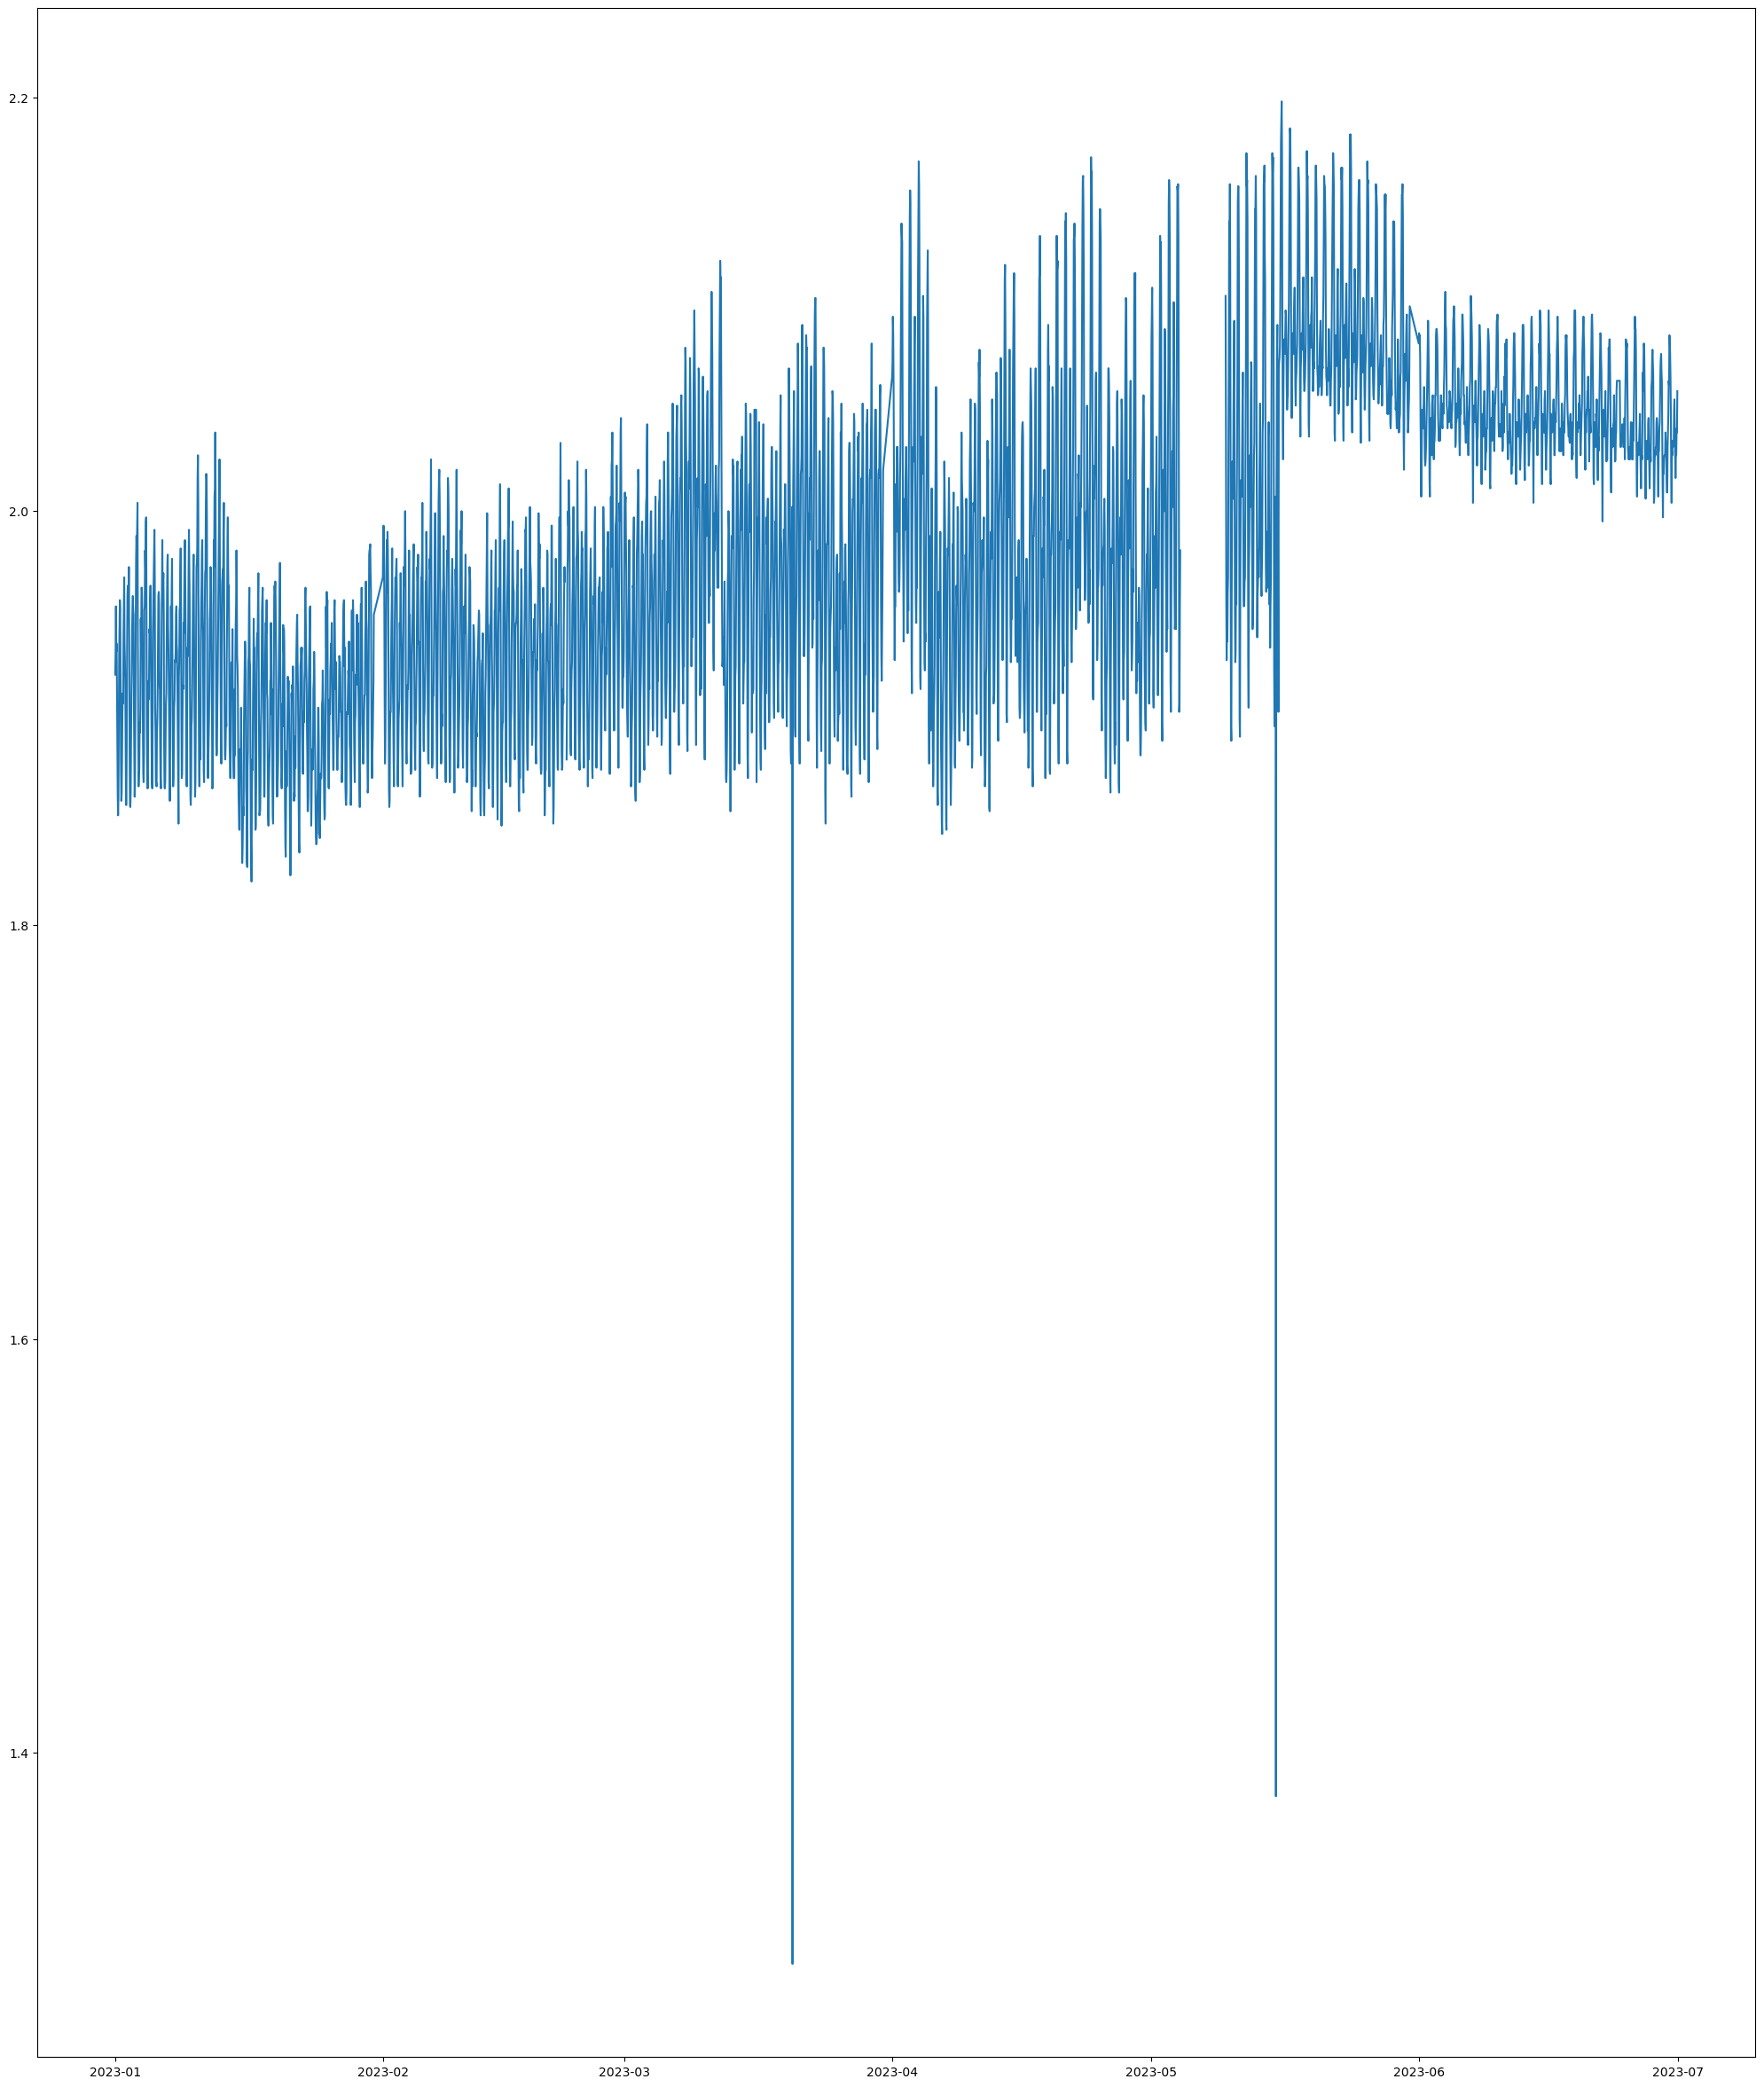

In [270]:
plt.figure(figsize=(25,30))
plt.plot(df_jan_thru_march_clean['Time'],df_jan_thru_march_clean['pressure_2'])

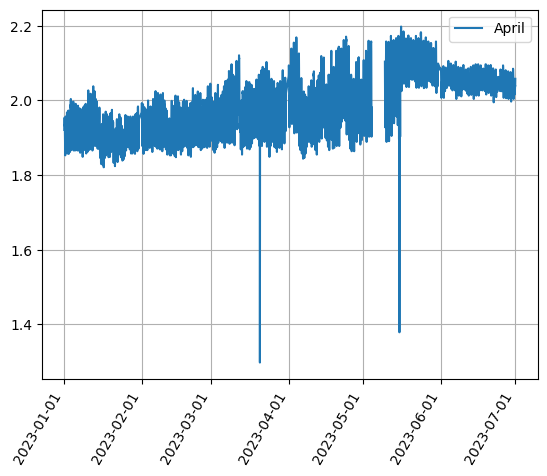

In [271]:
plot_kmeans_results(df_jan_thru_march_clean['Time'], df_jan_thru_march_clean['pressure_2'])

# linear regression - pressure_2 values, Jan ~ June

In [272]:
lin_reg = LinearRegression()

In [284]:
# transforms the columns into numpy arrays
pressure_2_array = np.array(df_jan_thru_march_clean['pressure_2'].dropna()).reshape(-1,1)
pressure_1_array = np.array(df_jan_thru_march_clean['pressure_1'].dropna()).reshape(-1,1)

In [285]:
# splits the arrays into train and test sets
pressure_2_train, pressure_2_test, pressure_1_train, pressure_1_test = train_test_split(pressure_2_array, pressure_1_array, random_state=104, test_size=0.25, shuffle=True)

In [286]:
# trains the model
lin_reg.fit(pressure_1_train, pressure_2_train)

LinearRegression()

In [287]:
# uses the model to predict 'pressure_2' values
predicted_pressure = lin_reg.predict(pressure_1_test)

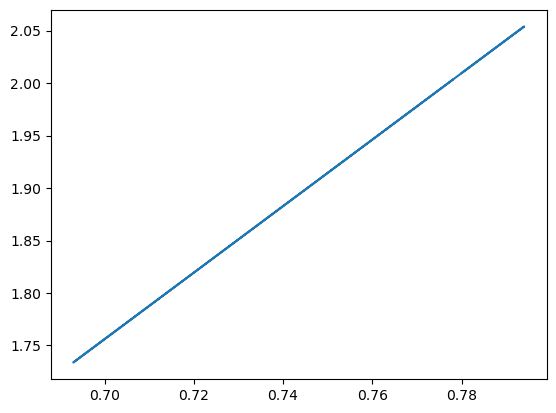

In [288]:
plt.plot(pressure_1_test,predicted_pressure)

# Subplots (Jan Thru June)

In [289]:
# subplots
fig = make_subplots(rows =2, cols =1)
fig.add_trace(
    go.Scatter(x=df_jan_thru_march_clean['Time'], y= df_jan_thru_march_clean['pressure_1']),
    row=1, col=1
)
fig.add_trace(go.Scatter(x= df_jan_thru_march_clean['Time'], y= df_jan_thru_march_clean['pressure_2']), row = 2, col =1)


In [290]:
fig_2 = make_subplots(rows = 1, cols = 2)
fig_2.add_trace(go.Scatter(x= df_jan_thru_march_clean['Time'], y = df_jan_thru_march_clean['electricity_1']), row = 1, col = 1)
fig_2.add_trace(go.Scatter(x = df_jan_thru_march_clean['Time'],y = df_jan_thru_march_clean['electricity_2']), row = 1, col = 2)

In [292]:
fig_3 = make_subplots(rows = 1, cols =1)
fig_3.add_trace(go.Scatter(x = df_jan_thru_march_clean['Time'], y = df_jan_thru_march_clean['outside_temperature']), row = 1, col = 1)


# autocorrelation plots (Jan thru June)

In [296]:
# acf -> remove trend 
# df_jan_thru_march_clean["diff"] = df_jan_thru_march_clean.diff()

# ax = df_jan_thru_march_clean.plot()
# ax.legend(ncol=5, 
#           loc='upper center',
#           bbox_to_anchor=(0.5, 1.0),
#           bbox_transform=plt.gcf().transFigure)
# for yr in range(2008, 2018):
#     ax.axvline(pd.to_datetime(str(yr)+"-01-01"), color ="red", linestyle = "--", alpha = 0.2)

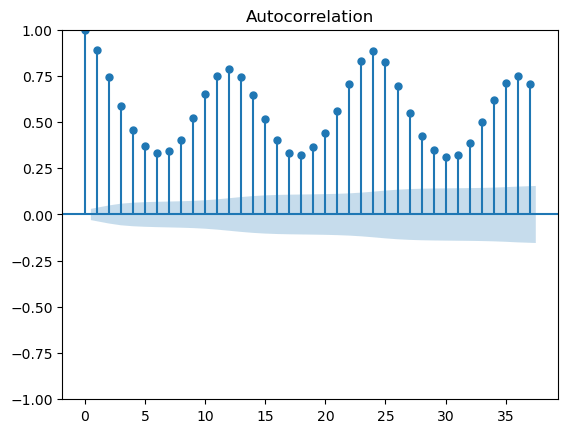

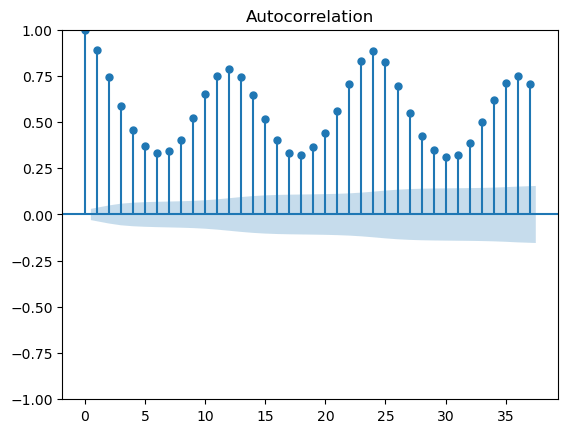

In [294]:
plot_acf(df_jan_thru_march_clean['pressure_2'].dropna())